In [1]:
import numpy as np
import tensorflow as tf
import random
import os
from PIL import Image
from PIL import ImageDraw
import sys

sys.path.append('/home/devyhia/A-Convolutional-Neural-Network-Cascade-for-Face-Detection/')

import param
import util
import data
import model

import Shared

Shared.select_gpu(1)

sess = tf.InteractiveSession()

In [22]:
from PIL import Image, ImageDraw, ImageFont

In [92]:
reload(param)
reload(util)

<module 'util' from '/home/devyhia/A-Convolutional-Neural-Network-Cascade-for-Face-Detection/util.py'>

In [2]:
#12net
input_12_node = tf.placeholder("float")
target_12_node = tf.placeholder("float", [None,1])
inputs_12 = np.zeros((param.mini_batch,param.img_size_12,param.img_size_12,param.input_channel), np.float32)

net_12 = model.detect_12Net(input_12_node,target_12_node)
net_12_calib = model.calib_12Net(input_12_node,target_12_node)
restorer_12 = tf.train.Saver([v for v in tf.all_variables() if "12det_" in v.name])
restorer_12.restore(sess, param.model_dir + "12-net.ckpt")
restorer_12_calib = tf.train.Saver([v for v in tf.all_variables() if "12calib_" in v.name])
restorer_12_calib.restore(sess, param.model_dir + "12-calib-net.ckpt")

In [3]:
#24net
input_24_node = tf.placeholder("float", [None, param.img_size_24, param.img_size_24, param.input_channel])
from_12_node = tf.placeholder("float",[None,16])
target_24_node = tf.placeholder("float", [None,1])
inputs_24 = np.zeros((param.mini_batch,param.img_size_24,param.img_size_24,param.input_channel), np.float32)

net_24 = model.detect_24Net(input_24_node,target_24_node,from_12_node)
net_24_calib = model.calib_24Net(input_24_node,target_24_node)
restorer_24 = tf.train.Saver([v for v in tf.all_variables() if "24det_" in v.name])
restorer_24.restore(sess, param.model_dir + "24-net.ckpt")
restorer_24_calib = tf.train.Saver([v for v in tf.all_variables() if "24calib_" in v.name])
restorer_24_calib.restore(sess, param.model_dir + "24-calib-net.ckpt")

In [4]:
#48net
input_48_node = tf.placeholder("float", [None, param.img_size_48, param.img_size_48, param.input_channel])
from_24_node = tf.placeholder("float",[None,128+16])
target_48_node = tf.placeholder("float", [None,1])
inputs_48 = np.zeros((param.mini_batch,param.img_size_48,param.img_size_48,param.input_channel), np.float32)

net_48 = model.detect_48Net(input_48_node,target_48_node,from_24_node)
net_48_calib = model.calib_48Net(input_48_node,target_48_node)
restorer_48 = tf.train.Saver([v for v in tf.all_variables() if "48det_" in v.name])
restorer_48.restore(sess, param.model_dir + "48-net.ckpt")
restorer_48_calib = tf.train.Saver([v for v in tf.all_variables() if "48calib_" in v.name])
restorer_48_calib.restore(sess, param.model_dir + "48-calib-net.ckpt")

In [172]:
img = Image.open('/home/devyhia/distracted.driver/Drive Safe/1500.jpg')

In [173]:
img = img.resize(tuple((0.5*np.array(img.size)).astype(np.int)))

In [174]:
#check if gray
if len(np.shape(img)) != param.input_channel:
    img = np.asarray(img)
    img = np.reshape(img,(np.shape(img)[0],np.shape(img)[1],1))
    img = np.concatenate((img,img,img),axis=2)
    img = Image.fromarray(img)

#12-net
#xmin, ymin, xmax, ymax, score, cropped_img, scale
result_box = util.sliding_window(img, param.thr_12, net_12, input_12_node)

#12-calib
result_db_tmp = np.zeros((len(result_box),param.img_size_12,param.img_size_12,param.input_channel),np.float32)
for id_,box in enumerate(result_box):
    result_db_tmp[id_,:] = util.img2array(box[5],param.img_size_12)

calib_result = net_12_calib.prediction.eval(feed_dict={input_12_node: result_db_tmp})
result_box = util.calib_box(result_box,calib_result,img)

#NMS for each scale
scale_cur = 0
scale_box = []
suppressed = []
for id_,box in enumerate(result_box):
    if box[6] == scale_cur:
        scale_box.append(box)
    if box[6] != scale_cur or id_ == len(result_box)-1:
        suppressed += util.NMS(scale_box)
        scale_cur += 1
        scale_box = [box]

result_box = suppressed
# result_box = util.NMS(result_box)
suppressed = []

In [175]:
len(result_box)

257

In [176]:
#24-net
result_db_12 = np.zeros((len(result_box),param.img_size_12,param.img_size_12,param.input_channel),np.float32)
result_db_24 = np.zeros((len(result_box),param.img_size_24,param.img_size_24,param.input_channel),np.float32)
for bid,box in enumerate(result_box):
    resized_img_12 = util.img2array(box[5],param.img_size_12)
    resized_img_24 = util.img2array(box[5],param.img_size_24)

    result_db_12[bid,:] = resized_img_12
    result_db_24[bid,:] = resized_img_24

from_12 = net_12.from_12.eval(feed_dict={input_12_node: result_db_12})
result = net_24.prediction.eval(feed_dict={input_24_node: result_db_24, from_12_node: from_12})
result_id = np.where(result > param.thr_24)[0]
result_box = [result_box[i] for i in result_id]

#24-calib
result_db_tmp = np.zeros((len(result_box),param.img_size_24,param.img_size_24,param.input_channel),np.float32)
for id_,box in enumerate(result_box):
    result_db_tmp[id_,:] = util.img2array(box[5],param.img_size_24)

calib_result = net_24_calib.prediction.eval(feed_dict={input_24_node: result_db_tmp})
result_box = util.calib_box(result_box,calib_result,img)

#NMS for each scale
scale_cur = 0
scale_box = []
suppressed = []
for id_,box in enumerate(result_box):
    if box[6] == scale_cur:
        scale_box.append(box)
    if box[6] != scale_cur or id_ == len(result_box)-1:
        suppressed += util.NMS(scale_box)
        scale_cur += 1
        scale_box = [box]

result_box = suppressed
# result_box = util.NMS(result_box)
suppressed = []

In [177]:
len(result_box)

42

In [178]:
#48-net
result_db_12 = np.zeros((len(result_box),param.img_size_12,param.img_size_12,param.input_channel),np.float32)
result_db_24 = np.zeros((len(result_box),param.img_size_24,param.img_size_24,param.input_channel),np.float32)
result_db_48 = np.zeros((len(result_box),param.img_size_48,param.img_size_48,param.input_channel),np.float32)

for bid,box in enumerate(result_box):
    resized_img_12 = util.img2array(box[5],param.img_size_12)
    resized_img_24 = util.img2array(box[5],param.img_size_24)
    resized_img_48 = util.img2array(box[5],param.img_size_48)

    result_db_12[bid,:] = resized_img_12
    result_db_24[bid,:] = resized_img_24
    result_db_48[bid,:] = resized_img_48

from_12 = net_12.from_12.eval(feed_dict={input_12_node: result_db_12})
from_24 = net_24.from_24.eval(feed_dict={input_24_node: result_db_24, from_12_node:from_12})

result = net_48.prediction.eval(feed_dict={input_48_node: result_db_48, from_24_node: from_24})
result_id = np.where(result > param.thr_48)[0]
result_box = [result_box[i] for i in result_id]


#global NMS
result_box = util.NMS(result_box)

#48-calib
result_db_tmp = np.zeros((len(result_box),param.img_size_48,param.img_size_48,param.input_channel),np.float32)
for id_,box in enumerate(result_box):
    result_db_tmp[id_,:] = util.img2array(box[5],param.img_size_48)

calib_result = net_48_calib.prediction.eval(feed_dict={input_48_node: result_db_tmp})
result_box = util.calib_box(result_box,calib_result,img)
# result_box = util.NMS(result_box)

In [179]:
len(result_box)

6

In [180]:
result_box

[[756,
  207,
  822,
  271,
  0.9960224628448486,
  <PIL.Image._ImageCrop image mode=RGB size=66x64 at 0x7F2B3AFE4110>,
  6],
 [393,
  159,
  489,
  256,
  0.9848068952560425,
  <PIL.Image._ImageCrop image mode=RGB size=96x97 at 0x7F2B3AFE4BD0>,
  10],
 [537,
  281,
  641,
  384,
  0.9805200695991516,
  <PIL.Image._ImageCrop image mode=RGB size=104x103 at 0x7F2B3AFE4190>,
  11],
 [651,
  252,
  726,
  325,
  0.9796295762062073,
  <PIL.Image._ImageCrop image mode=RGB size=75x73 at 0x7F2B3AFE4E10>,
  9],
 [323,
  86,
  343,
  106,
  0.9597925543785095,
  <PIL.Image._ImageCrop image mode=RGB size=20x20 at 0x7F2B3AFE4090>,
  0],
 [206,
  126,
  268,
  188,
  0.6498357653617859,
  <PIL.Image._ImageCrop image mode=RGB size=62x62 at 0x7F2B3AFE45D0>,
  5]]

In [79]:
highest_score = sorted(result_box, reverse=True, key=lambda x: (x[4], (x[2]-x[0])*(x[3]-x[1])))
# most_conf = reduce(select_most_confidenc_and_largest_size, result_box, (0,0, {}))[2]

In [183]:
draw = ImageDraw.Draw(img)
for box in sorted([ box for box in result_box], reverse=True, key=lambda x: x[4]):
#     height = box[3] - box[1]
#     box[1] -= 0.1*height
#     box[3] += 0.1*height
    draw.rectangle((box[0],box[1],box[2],box[3]), outline="red")
    font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
    ttFont = ImageFont.truetype(font_path, 20)
    draw.text((box[0], box[1]), "{0:.2f}".format(box[4]), font=ttFont)

# draw.rectangle((most_conf[0],most_conf[1],most_conf[2],most_conf[3]), outline="green")
# font_path=os.environ.get("FONT_PATH", "/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf")
# ttFont = ImageFont.truetype(font_path, 20)
# draw.text((most_conf[0], most_conf[1]), "{0:.2f}".format(most_conf[4]), font=ttFont)

In [20]:
img.save('/home/devyhia/test0.jpg')

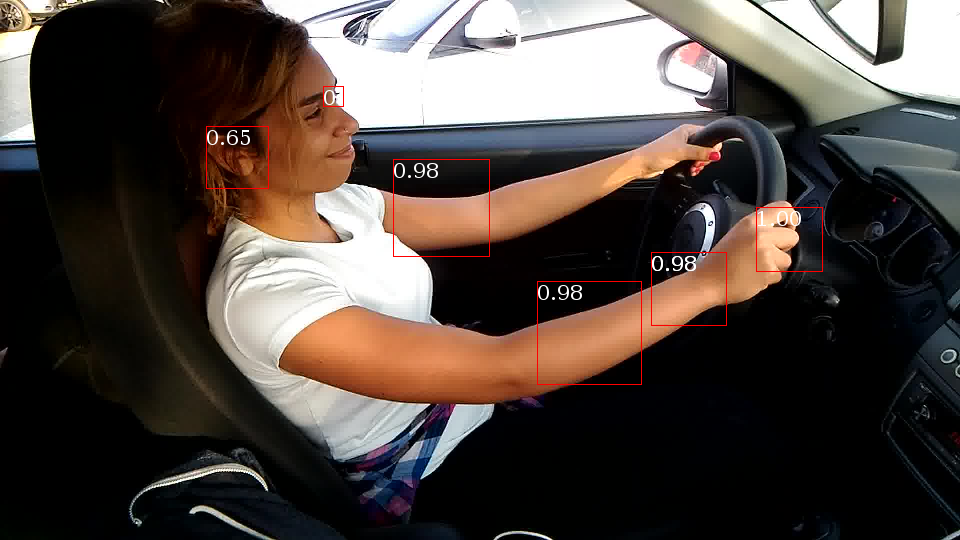

In [184]:
img